In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

from deepctr.feature_column import SparseFeat, VarLenSparseFeat, get_feature_names
from deepctr.models import DeepFM


In [2]:
data = pd.read_csv("./movielens_sample.txt")
sparse_features = ["movie_id", "user_id", "gender", "age", "occupation", "zip"]
data[sparse_features] = data[sparse_features].astype(str)
target = ["rating"]
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     200 non-null    object
 1   movie_id    200 non-null    object
 2   rating      200 non-null    int64 
 3   timestamp   200 non-null    int64 
 4   title       200 non-null    object
 5   genres      200 non-null    object
 6   gender      200 non-null    object
 7   age         200 non-null    object
 8   occupation  200 non-null    object
 9   zip         200 non-null    object
dtypes: int64(2), object(8)
memory usage: 15.8+ KB


,user_id,movie_id,rating,timestamp,title,genres,gender,age,occupation,zip
0,3299,235,4,968035345,Ed Wood (1994),Comedy|Drama,F,25,4,19119
1,3630,3256,3,966536874,Patriot Games (1992),Action|Thriller,M,18,4,77005
2,517,105,4,976203603,"Bridges of Madison County, The (1995)",Drama|Romance,F,25,14,55408
3,785,2115,3,975430389,Indiana Jones and the Temple of Doom (1984),Action|Adventure,M,18,19,29307
4,5848,909,5,957782527,"Apartment, The (1960)",Comedy|Drama,M,50,20,20009


In [8]:
# this is used as key in movilens_age_vocabulary.csv
data["age"].value_counts().sort_index()

1      6
18    36
25    72
35    36
45    13
50    25
56    12
Name: age, dtype: int64

In [9]:
# use hashing encoding on the fly for sparse features, 
# and process sequence features
genres_list = list(map(lambda x: x.split('|'), data["genres"].values))
genres_length = np.array(list(map(len, genres_list)))
max_len = max(genres_length)
genres_list[:2]

[['Comedy', 'Drama'], ['Action', 'Thriller']]

In [10]:
genres_list = pad_sequences(genres_list, maxlen=max_len, padding="post", dtype=object, value=0).astype(str)
genres_list[:2]

array([['Comedy', 'Drama', '0', '0', '0'],
       ['Action', 'Thriller', '0', '0', '0']], dtype='<U10')

In [11]:
# set hashing space for each sparse field 
# and generate feature config for sequence feature
fixlen_feature_columns = [SparseFeat(feat, data[feat].nunique() * 5, embedding_dim=4, use_hash=True,
                                         vocabulary_path='./movielens_age_vocabulary.csv' if feat == 'age' else None,
                                         dtype='string')
                              for feat in sparse_features]
varlen_feature_columns = [
    VarLenSparseFeat(SparseFeat('genres', vocabulary_size=100, embedding_dim=4,
                                use_hash=True, dtype="string"),
                        maxlen=max_len, combiner='mean',
                        )]  # Notice : value 0 is for padding for sequence input feature
linear_feature_columns = fixlen_feature_columns + varlen_feature_columns
dnn_feature_columns = fixlen_feature_columns + varlen_feature_columns
feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)
feature_names

['movie_id', 'user_id', 'gender', 'age', 'occupation', 'zip', 'genres']

In [12]:
# generate input data for model
model_input = {name: data[name] for name in feature_names}
model_input["genres"] = genres_list

In [15]:
# define model, compile, and train
model = DeepFM(linear_feature_columns, dnn_feature_columns, task='regression')
model.compile("adam", "mse", metrics=['mse'], )

In [16]:
BATCH_SIZE = 256
EPOCHS = 40
history = model.fit(model_input, data[target].values,
                                batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=2, validation_split=0.2, )

Epoch 1/40
1/1 - 1s - loss: 14.3000 - mse: 14.3000 - val_loss: 13.3896 - val_mse: 13.3896
Epoch 2/40
1/1 - 0s - loss: 14.1693 - mse: 14.1693 - val_loss: 13.2580 - val_mse: 13.2580
Epoch 3/40
1/1 - 0s - loss: 14.0149 - mse: 14.0149 - val_loss: 13.1133 - val_mse: 13.1133
Epoch 4/40
1/1 - 0s - loss: 13.8466 - mse: 13.8466 - val_loss: 12.9561 - val_mse: 12.9561
Epoch 5/40
1/1 - 0s - loss: 13.6645 - mse: 13.6645 - val_loss: 12.7852 - val_mse: 12.7852
Epoch 6/40
1/1 - 0s - loss: 13.4668 - mse: 13.4668 - val_loss: 12.5982 - val_mse: 12.5982
Epoch 7/40
1/1 - 0s - loss: 13.2508 - mse: 13.2508 - val_loss: 12.3937 - val_mse: 12.3937
Epoch 8/40
1/1 - 0s - loss: 13.0139 - mse: 13.0139 - val_loss: 12.1697 - val_mse: 12.1697
Epoch 9/40
1/1 - 0s - loss: 12.7549 - mse: 12.7549 - val_loss: 11.9233 - val_mse: 11.9233
Epoch 10/40
1/1 - 0s - loss: 12.4712 - mse: 12.4712 - val_loss: 11.6528 - val_mse: 11.6528
Epoch 11/40
1/1 - 0s - loss: 12.1601 - mse: 12.1601 - val_loss: 11.3560 - val_mse: 11.3560
Epoch 12

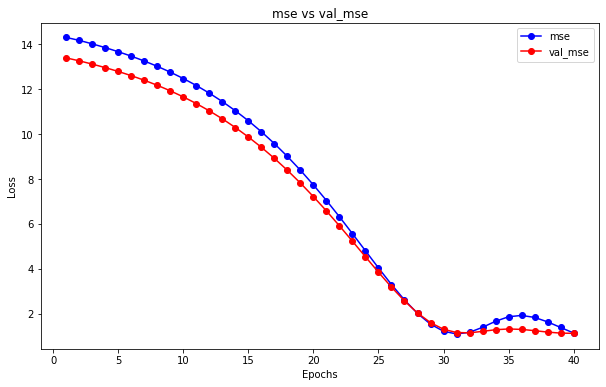

In [17]:
import matplotlib.pyplot as plt
# Extract loss and validation loss values
def plot_history(history, train_metric: str, val_metric: str):
    history_dict = history.history

    loss = history_dict[train_metric]
    val_loss = history_dict[val_metric]
    # Create an array with epoch numbers
    epochs = range(1, len(loss) + 1)

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, loss, 'bo-', label=train_metric)
    plt.plot(epochs, val_loss, 'ro-', label=val_metric)
    plt.title(f'{train_metric} vs {val_metric}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_history(history, "mse", "val_mse")